In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

#!pip install stellargraph

!pip install networkx
import networkx as nx

!pip install scikit-plot

import sys
sys.path.append('/content/drive/MyDrive')
from inductiveGRL.graphconstruction import GraphConstruction
from inductiveGRL.hinsage import HinSAGE_Representation_Learner, HinSAGE_Representation_Learner_Ind_TB, HinSAGE_Representation_Learner_Nrecent
import stellargraph as sg


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Read in data 

Read in the data and split it into training and test datasets.

In [2]:
data_full = pd.read_csv('/content/drive/MyDrive/AI Dissertation /data/bs140513_032310.csv')
data_full["index"] = data_full.index
# add a column to data for customer id and merchant id with prefix 1: C and 2: M
data_full['merchant_id'] = data_full['merchant'].str.replace("M", '2').str.replace("'", "")
data_full['customer_id'] = data_full['customer'].str.replace("C", '1').str.replace("'", "")
data_full['category'] = data_full['category'].str.replace("'", "")
data_full['age'] = data_full['age'].str.replace("'", "")

category_oh = pd.get_dummies(data_full['category'], prefix='category')
data_full = data_full.join(category_oh)

age_oh = pd.get_dummies(data_full['age'], prefix='age')
data_full = data_full.join(age_oh)

def split_data(data, split_start, split_end):
    return data.loc[(data['step'] >= split_start) & (data['step'] <= split_end)]

data_train = split_data(data_full, 0, 30)
data_test = split_data(data_full, 31, 40)


## 1.2 Form the Graph

In [3]:
def data_to_graph(dataset):
  ### nodes
  #node_customers = pd.DataFrame([1]*len(dataset.customer_id.unique())).set_index(dataset.customer_id.unique())
  node_customers = dataset[["step", "customer_id", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U"]].drop_duplicates(subset=["customer_id"]).set_index("customer_id")
  #print(node_customers.loc["1369566106"])
  node_merchants = pd.DataFrame([1]*len(dataset.merchant_id.unique())).set_index(dataset.merchant_id.unique())

  # transaction node data
  node_txns = dataset[["step", "amount", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", 
                       "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", 
                       "category_es_travel", "category_es_wellnessandbeauty", "index"]]

  ### edges
  # customer to transaction edges
  edge_customer = dataset[["customer_id", "index"]]

  # transaction to merchant edges
  edge_merchant = dataset[["index", "merchant_id"]]

  nodes = {"customer":dataset.customer_id, "merchant":dataset.merchant_id, "transaction":dataset.index}
  edges = [zip(edge_customer.customer_id, edge_customer.index), zip(edge_merchant.index, edge_merchant.merchant_id)]
  features = {"transaction": node_txns, 'customer': node_customers, 'merchant': node_merchants}

  graph = GraphConstruction(nodes, edges, features)
  S = graph.get_stellargraph()
  return S

S = data_to_graph(data_train)
#print(S.info())

## Inductive graph data is train + test data
inductive_graph_data = pd.concat((data_train, data_test))
S_ind = data_to_graph(inductive_graph_data)
#print(S_ind.info())

# 2. Train the model


In [4]:
num_samples = [2, 5]
embedding_node_type = "transaction"

hinsage = HinSAGE_Representation_Learner_Nrecent(64, num_samples, embedding_node_type)
trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(data_train.index), data_train['fraud'], batch_size=5, epochs=3) 

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
13340/13340 [==============================] - 5508s 413ms/step - loss: 0.0596 - val_loss: 0.0390
Epoch 2/3
13340/13340 [==============================] - 5498s 412ms/step - loss: 0.0324 - val_loss: 0.0505
Epoch 3/3
16675/16675 [==============================] - 5440s 326ms/step


# 3. Inductive Step


In [5]:
inductive_emb = hinsage.inductive_step_hinsage(S_ind, trained_hinsage_model, data_test.index, batch_size=5)

5953/5953 [==============================] - 644s 108ms/step


### 4. Classification: predictions based on inductive embeddings

Select your preferred classification model

In [6]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

If requested, the original transaction features are added to the generated embeddings. If these features are added, a baseline consisting of only these features (without embeddings) is included to analyze the net impact of embeddings on the predictive performance.

In [7]:
train_labels = data_train['fraud']

add_additional_data = True

if add_additional_data is True:
    train_emb_m = pd.merge(train_emb, data_train[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]], left_index=True, right_index=True)
    inductive_emb_m = pd.merge(inductive_emb, data_test[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]], left_index=True, right_index=True)

    baseline_train = data_train[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]]
    baseline_inductive = data_test[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]]

    classifier.fit(baseline_train, train_labels)
    baseline_predictions = classifier.predict_proba(baseline_inductive)

    classifier.fit(train_emb_m, train_labels)
    predictions = classifier.predict_proba(inductive_emb_m)
    
else:
  classifier.fit(train_emb, train_labels)
  predictions = classifier.predict_proba(inductive_emb)


### 5. Evaluation

Given the highly imbalanced nature of our dataset, we evaluate the results based on precision-recall curves. 

Average precision-recall score XGBoost: 0.9020724770
Average precision-recall score XGBoost: 0.8420009173


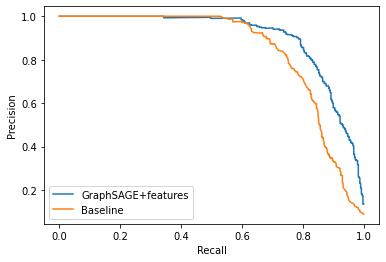

In [8]:
from inductiveGRL.evaluation import Evaluation
inductive_labels = data_full.loc[inductive_emb.index]['fraud']

graphsage_evaluation = Evaluation(predictions, inductive_labels, "GraphSAGE+features") 
graphsage_evaluation.pr_curve()

if add_additional_data is True:
    baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
    baseline_evaluation.pr_curve()

# 6. Time step testing

In this section I am testing to see the distribution of fraud found for each time step. Does the model identify fraud in an uniform distribution?


Baseline:
Precision: 0.9146757679180887
Recall: 0.67
GraphSAGE:
Precision: 0.9461279461279462
Recall: 0.7025


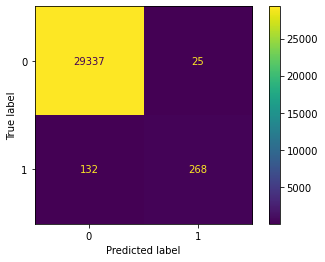

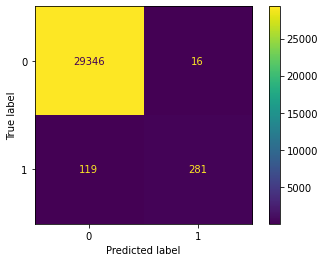

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Baseline:")
ConfusionMatrixDisplay.from_predictions(inductive_labels, np.argmax(baseline_predictions, axis=1))
print("Precision:", precision_score(inductive_labels, np.argmax(baseline_predictions, axis=1)))
print("Recall:", recall_score(inductive_labels, np.argmax(baseline_predictions, axis=1)))

print("GraphSAGE:")
ConfusionMatrixDisplay.from_predictions(inductive_labels, np.argmax(predictions, axis=1))
print("Precision:", precision_score(inductive_labels, np.argmax(predictions, axis=1)))
print("Recall:", recall_score(inductive_labels, np.argmax(predictions, axis=1)))

In [10]:
#print(predictions)
#print(inductive_labels)
graph_predictions = np.argmax(predictions, axis=1)
base_preds = np.argmax(baseline_predictions, axis=1)


# get a list of baseline true positives and of graph true positives
baseline_tp = []
baseline_time = []
graph_tp = []
graph_time = []
i=0
for index, value in inductive_labels.items():
  # baseline true positives
  if (value == base_preds[i]) and (value == 1):
    baseline_tp.append(index)
    baseline_time.append(inductive_graph_data.loc[index, "step"])
  # graph true positives
  if value == graph_predictions[i] and value == 1:
    graph_tp.append(index)
    graph_time.append(inductive_graph_data.loc[index, "step"])
  i = i+1 


for i in range(129,137):
  print("Baseline count", i, ":", baseline_time.count(i))
  print("GraphSAGE count", i, ":", graph_time.count(i))

Baseline count 129 : 0
GraphSAGE count 129 : 0
Baseline count 130 : 0
GraphSAGE count 130 : 0
Baseline count 131 : 0
GraphSAGE count 131 : 0
Baseline count 132 : 0
GraphSAGE count 132 : 0
Baseline count 133 : 0
GraphSAGE count 133 : 0
Baseline count 134 : 0
GraphSAGE count 134 : 0
Baseline count 135 : 0
GraphSAGE count 135 : 0
Baseline count 136 : 0
GraphSAGE count 136 : 0


Baseline
Precision: 0.8707692307692307
Recall: 0.7075

GraphSAGE
Precision: 0.8552278820375335
Recall: 0.7975


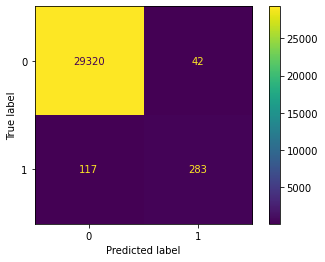

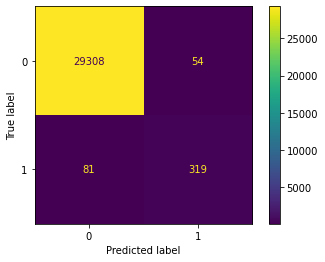

In [11]:
def classify_probabilities(prediction_probs, decision_boundary):
  pred_c = []
  for p in prediction_probs:
    if p > decision_boundary:
      pred_c.append(1)
    else:
      pred_c.append(0)
  return pred_c

print("Baseline")
baseline_pred_c = classify_probabilities(baseline_predictions[:, 1], 0.34)
ConfusionMatrixDisplay.from_predictions(inductive_labels, baseline_pred_c)
print("Precision:", precision_score(inductive_labels, baseline_pred_c))
print("Recall:", recall_score(inductive_labels, baseline_pred_c))

print()
print("GraphSAGE")
pred_c = classify_probabilities(predictions[:, 1], 0.29)
ConfusionMatrixDisplay.from_predictions(inductive_labels, pred_c)
print("Precision:", precision_score(inductive_labels, pred_c))
print("Recall:", recall_score(inductive_labels, pred_c))